# Generating Dispersion Diagrams with FenicsX

Josh Tempelman

University of Illinois at Urbana Champaign

jrt7@illinois.edu

In [1]:
# ################################################## #
# Genearal imports                                   #
# ################################################## #
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ################################################## #
# Imports for plotting                               #
# ################################################## #
import matplotlib.pyplot as plt
from dolfinx.io import gmshio
import pyvista
pyvista.start_xvfb()

# ################################################## #
# Imports for the meshing                            #
# ################################################## #
import gmsh
from MeshFunctions      import get_mesh_SquareSpline,get_mesh_SquareMultiSpline
from dolfinx.plot       import create_vtk_mesh
from dolfinx.io         import XDMFFile
from dolfinx.io.gmshio  import model_to_mesh

from FEM_Functions import *
from PostProcess import*

# ################################################## #
# Imports for finite element modeling                #
# ################################################## #
from mpi4py import MPI
import dolfinx_mpc
import dolfinx
from dolfinx.fem    import Function, FunctionSpace, VectorFunctionSpace
from dolfinx.mesh   import create_unit_square 
from dolfinx.mesh   import create_rectangle
from dolfinx.fem    import form
from dolfinx.fem.petsc import assemble_matrix
from dolfinx    import plot
from dolfinx.io import gmshio
from mpi4py     import MPI
from dolfinx    import fem
from ufl        import TrialFunction, TestFunction, grad, dx, dot, nabla_div, Identity, nabla_grad, inner, sym
from petsc4py.PETSc import ScalarType
from slepc4py   import SLEPc
from petsc4py   import PETSc
from typing     import List
import scipy.sparse
from scipy.sparse.linalg import eigsh
from scipy import sparse


## Part 1: Generating a mesh

We start by defining some parameters for the void in our square unit cell

In [2]:
######################################################################
#                      Domain  Inputs                                #
######################################################################
#   a_len               Charecterstic unit cell length (primitive basis)
#   r                   vector of points to fit spline to
#   Nquads              Number of quadrants to repeat spline through (radially)
#   offset              Offset angle for inclusion geometry
#   iscut               Choose if inclusion is void or an added domain
#   dvar                Design variable to probe 
######################################################################
a_len       = .1
dvar        =  1/2       
r           = np.array([1,dvar,.2,.8,.3])*a_len*.75
offset      = 0*np.pi
design_vec  = np.concatenate( (r/a_len, [offset] ))
Nquads      = 4

In [3]:
# Set file name to save figures based on input vector
name = 'dvec'
for k in range(len(design_vec)):
    name += '_' + str(int(100*np.round(design_vec[k],2)))


######################################################################
#                  Phsyical  Params                                  #
######################################################################
#   c                   Speed of sound in media
#   rho                 Desnity
######################################################################
c           = [1500,5100]   # if solid inclusion (mutlple materail model)
rho         = [1e3,7e3]     # if solid inclusion (mutlple materail model) 
c           = [30]          # if void inclusion  (if iscut)
rho         = [1.2]         # if void inclusion  (if iscut)

######################################################################
#                      Mesh Inputs                                   #
######################################################################
#   refinement_level    Choose ratio of how dense mesh gets around refinement field 
#   refinement_dist     Maximum distance of refinement field from refined edges
#   isrefined           Choose whether or not to refine mesh around internal edges
#   meshalg             Meshing algorithm for gmsh to use
#   da                  Nominal Mesh Density
######################################################################
da                  =   a_len/25
meshalg             =   7
refinement_level    =   3
refinement_dist     =   a_len/10

######################################################################
#                        Solver inputs                               #
######################################################################
# npi       Number of points to loop through i-th cut of IBZ
# nvec      Number of eigenvectrs to solve for in each step
# fspace    Function space to use
######################################################################
np1     = 20
np2     = 20
np3     = 20
nvec    = 20
fspace  = 'CG'


Now we can run the function  `get_mesh_SquareSpline` to get a mesh using the `gmsh` api

In [14]:
meshalg                 = 6
cut = False
gmsh.model, xpt, ypt    = get_mesh_SquareSpline(a_len ,da,r,Nquads,offset,meshalg,
                                                refinement_level,refinement_dist,
                                                isrefined = True, cut = cut)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
 --------- ERROR HERE --------------
Info    : Error in transformation from curve 2 (27-25) to 4 (28-27) (minimal transformed node distances 0 0.141421, tolerance 1.41563e-09)
Info    : Error in transformation from curve 3 (26-28) to 1 (25-26) (minimal transformed node distances 0.223607 0.1, tolerance 1.41563e-09)
 --------- ERROR HERE --------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.0800535s, CPU 0.072055s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 101 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0767458s, CPU 0.07854s)
Info    : 3021 nodes 61

Now we convert the gmsh object to a dolfinx mesh. The `model_to_mesh` module returns the mesh in the correct format along with `ct` which account for domain tags constructed in `gmsh`. Thses tags will be needed if assigneing material propeties to multiple domains

In [15]:
#################################################################
#            Import to dolfinx and save as xdmf                 #
#################################################################
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct)

## Visualization
 
We can now use `pyvista` to visual the mesh


No module named 'trame'

Falling back to a static output.
  warnings.warn(



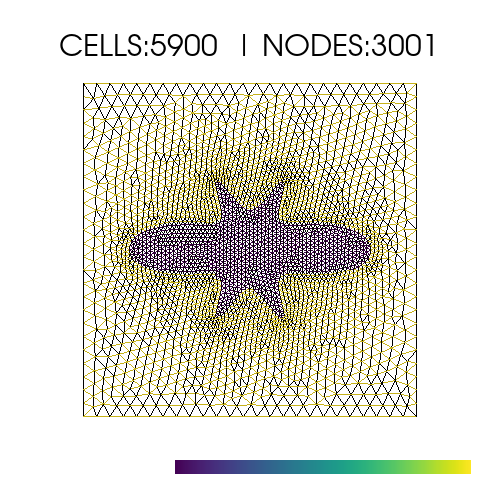

In [16]:
V = FunctionSpace(mesh,(fspace,1))
v = Function(V)
pyvista.global_theme.font.title_size  = 10
plotter = pyvista.Plotter(window_size=(500,500))
grid = pyvista.UnstructuredGrid(*create_vtk_mesh(mesh, mesh.topology.dim))
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_data["Marker"] = 1-ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")
# actor = plotter.add_mesh(grid, color = 'w', show_edges=True, line_width= 2, edge_color= 'k', style='wireframe')
actor = plotter.add_mesh(grid, style='wireframe')
# actor = plotter.add_mesh(grid, show_edges=True, line_width= 1, edge_color= 'k')
plotter.set_background('white', top='white')
plotter.view_xy()
plotter.camera.tight(padding=0.5)
plotter.add_title('CELLS:'+str(ct.values.shape[0])+ '  | NODES:'+str(v.vector[:].shape[0]), color = 'k', font_size = 12)
plotter.show()

Now we set up the physical problem. The quanties are $c$ and $\rho$, for the equation

$$
c^2\nabla u(x,t) - \frac{\partial^2}{\partial t^2}u(x,t) = 0
$$

If the inclusion gemoetry is not a cut out, then ehere are two domains in the unit cell that both need ot be 

In [17]:

if cut: 
    c           = [1500,5100]
    rho         = [1e3,7e3]
else:    
    c           = [5500]
    rho         = [7e3]

Now we solve the entire band structure using the finite-element method. The following code solves the eigenproblem along  the $\Gamma$-X-M-$\Gamma$ boundary of the IBZ
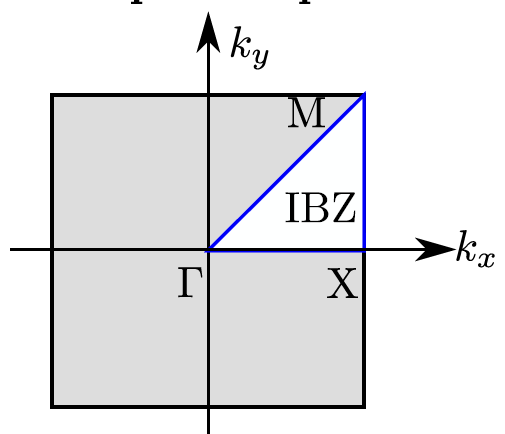

This could be changedby modifying the tuble of high-symmetry points to consider

In [23]:

# # Define the high symmetry points of the lattice
# P1 = [0,0] # Gamma 
# P2 = [1,0] # X
# P2 = [1,1] # K
# HS = [P1,P2,P3,P1]

# # Now solve the 

# # Define the numnber of eigenvectors to solve for each soltuion

# # Define number of eigensolutions desired

c           = [1500,5100]
rho         = [1e3,7e3]
np1 = 21
np2 = 21
np3 = 21
evals_disp, evec_all, mpc = solve_bands(
        np1, np2, np3, nvec, a_len, c, rho, fspace, mesh,ct)

# Define the high symmetry points of the lattice
# P1 = [0,0] # Gamma 
# P2 = [np.pi/a_len, 0] # X
# P3 = [np.pi/a_len, np.pi/a_len] # K
# P4 = [0, np.pi/a_len] # K
# HSpts = [P1,P2,P3,P4,P1]


# # Define the numnber of eigenvectors to solve for each soltuion
# nvec = 20

# # Define number of eigensolutions desired
# nsol = len(HSpts)*15

# # evals_disp, evec_all, mpc = solve_bands(
# # np1, np2, np3, nvec, a_len, c, rho, fspace, mesh,ct)

# evals_disp, evec_all, mpc, KX, KY = solve_bands_repo(
# HSpts  = HSpts,
# nsol  = nsol, 
# nvec = nvec, 
# a_len = a_len, 
# c = c, 
# rho = rho, 
# fspace = fspace, 
# mesh = mesh,
# ct = ct
# )

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure .... 
Computing Gamma to  X


INFO:root:running build_ext
INFO:root:building 'libffcx_forms_83213dc2d778661cbbb6e36f5c92e780245f535c' extension
INFO:root:/home/jrt7/anaconda3/envs/fenicsx-env/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/jrt7/anaconda3/envs/fenicsx-env/include -fPIC -O2 -isystem /home/jrt7/anaconda3/envs/fenicsx-env/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/jrt7/anaconda3/envs/fenicsx-env/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/jrt7/anaconda3/envs/fenicsx-env/include -fPIC -I/home/jrt7/anaconda3/envs/fenicsx-env/lib/python3.10/site-packages/ffcx/codegeneration -I/home/jrt7/anaconda3/envs/fenicsx-env/include/python3.10 -c libffcx_forms_83213dc2d778661cbbb6e36f5c92e780245f535c.c -o ./libffcx_forms_83213dc2d778661cbbb6e36f5c92e780245f535c.o -O2 -g0
INFO:root:/home/jrt7/anaconda3/envs/fenicsx-env/bin/x86_64-conda-linux-gnu

Computing X to  M


INFO:root:/home/jrt7/anaconda3/envs/fenicsx-env/bin/x86_64-conda-linux-gnu-cc -shared -Wl,--allow-shlib-undefined -Wl,-rpath,/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-rpath-link,/home/jrt7/anaconda3/envs/fenicsx-env/lib -L/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,--allow-shlib-undefined -Wl,-rpath,/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-rpath-link,/home/jrt7/anaconda3/envs/fenicsx-env/lib -L/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--disable-new-dtags -Wl,--gc-sections -Wl,--allow-shlib-undefined -Wl,-rpath,/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-rpath-link,/home/jrt7/anaconda3/envs/fenicsx-env/lib -L/home/jrt7/anaconda3/envs/fenicsx-env/lib -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/jrt7/anaconda3/envs/fenicsx-env/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/jrt7/anaconda3/envs/fenicsx-env/includ

Computing M to Gamma


INFO:root:/home/jrt7/anaconda3/envs/fenicsx-env/bin/x86_64-conda-linux-gnu-cc -shared -Wl,--allow-shlib-undefined -Wl,-rpath,/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-rpath-link,/home/jrt7/anaconda3/envs/fenicsx-env/lib -L/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,--allow-shlib-undefined -Wl,-rpath,/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-rpath-link,/home/jrt7/anaconda3/envs/fenicsx-env/lib -L/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--disable-new-dtags -Wl,--gc-sections -Wl,--allow-shlib-undefined -Wl,-rpath,/home/jrt7/anaconda3/envs/fenicsx-env/lib -Wl,-rpath-link,/home/jrt7/anaconda3/envs/fenicsx-env/lib -L/home/jrt7/anaconda3/envs/fenicsx-env/lib -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/jrt7/anaconda3/envs/fenicsx-env/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/jrt7/anaconda3/envs/fenicsx-env/includ

Time to compute Dispersion 23.385
Band Compuation Complete
-----------------
N_dof....5900
N_vectors....20
N_wavenumbers....63
T total....23.385


Collect bands and bandgaps

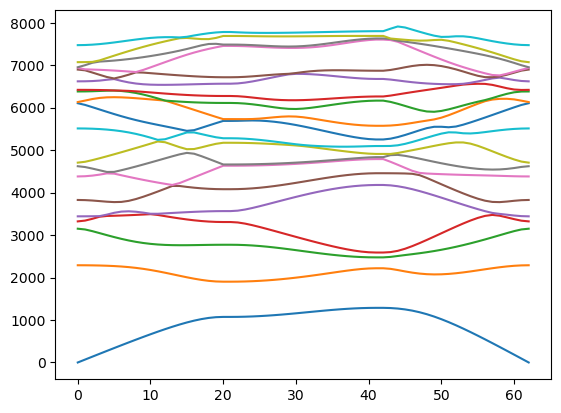

In [24]:
bgnrm, gapwidths, gaps, lowbounds, highbounds = getbands(np.array(evals_disp))
BGdata = gapwidths
plt.plot(evals_disp)

ValueError: x and y must have same first dimension, but have shapes (60,) and (63,)

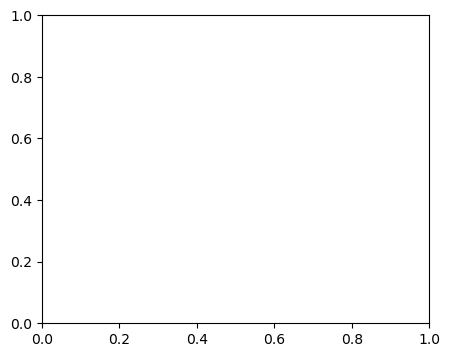

In [25]:
from matplotlib.patches import Rectangle
plt = plotbands(np.array(evals_disp))

  mycmap = plt.cm.get_cmap('seismic', 10)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



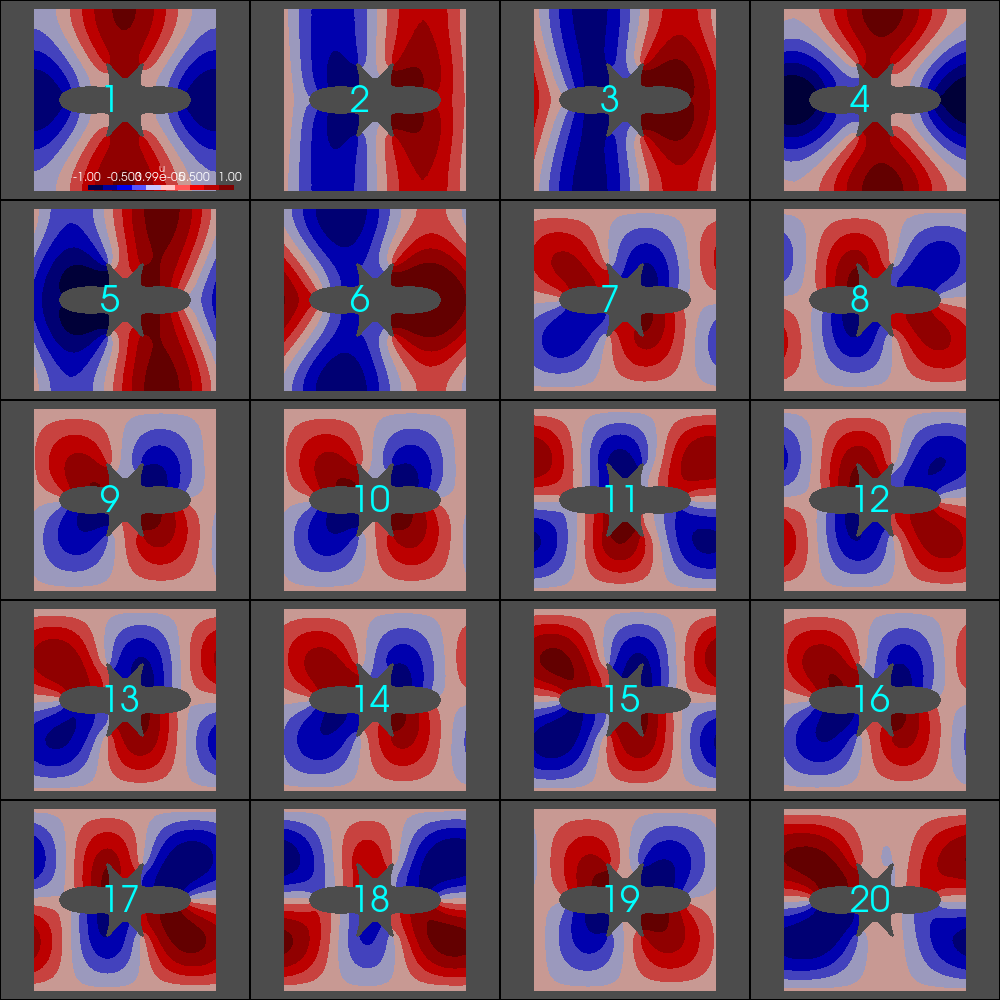

In [12]:
testload = np.array(evec_all) #np.load('data//testFile.npy')
plotter = pyvista.Plotter(shape=(5,4) , window_size=(1000,1000))
###########################################################
# Post-processing the eigenvectors
###########################################################
euse = 0
for i in range(5):
    for j in range(4):
        plotter.subplot(i,j)
        et = testload[euse,:,3]; euse += 1
        vr = Function(V)
        vi = Function(V)
        vr.vector[:] = np.real(et)
        vi.vector[:] = np.imag(et)
        vr.x.scatter_forward()
        mpc.backsubstitution(vr.vector)
        vi.x.scatter_forward()
        mpc.backsubstitution(vi.vector)


        ###########################################################
        # Plotting eigenvectors with pyvista
        ###########################################################
        # mycmap = plt.cm.get_cmap('coolwarm', 10)
        mycmap = plt.cm.get_cmap('seismic', 10)
        u = Function(V)
        cells, types, x = plot.create_vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(cells, types, x)
        grid.point_data["u"] = u.x.array
        u.vector.setArray(vr.vector[:]/np.max(vr.vector[:])*np.sign(vr.vector[10]))
        edges = grid.extract_all_edges()
        warped = grid.warp_by_scalar("u", factor=0)
        plotter.add_mesh(warped, show_edges=False, show_scalar_bar=True, scalars="u",cmap=mycmap)
        # plotter.add_mesh(grid, style = 'wireframe', line_width = .5, color = 'black')
        plotter.view_xy()
        plotter.add_text(str(euse), position=[100,80], color='cyan')
        plotter.camera.tight(padding=0.1)

plotter.show()